# Blue Food

Visualizing protein supply and how the practices generating that protein supply affect the ocean using a heirarchical relationship.

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted. 

*Author: Rachel Thoms
<br>Created: 08 24 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Chart type: [Sunburst](https://vega.github.io/vega/examples/sunburst/)
- Value: Protein Supply (g/capita/day)

## Data

- Data: [ocn_calcs_015_blue_food_protein_supply](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_calcs_015_blue_food_protein_supply)
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/9e1b3cad-db6f-44b0-b6fb-048df7b6c680)
- Source: [FAO Food Balance Sheet](http://www.fao.org/faostat/en/#data/FBS)

## Preparation

### Vega

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 600
widget_height = 600

## Visualization

### Queries

#### Testing

``` gid_0 = 'JPN' ``` used as stand-in for parameterized ```geostore_id={{geostore_id}}``` in production version

```sql
SELECT alias.iso as gid_0, data.area, year, item as id, parent, size, value as protein, analysis_category, product FROM (SELECT * FROM foo_061_rw1_blue_food_supply_edit) data INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area WHERE iso='JPN' ORDER BY analysis_category ASC, id ASC
```

#### Parameterization

```sql
SELECT gadm.gid_0 as gid_0, data.area, year, item as id, parent, size, value as protein, analysis_category, product 
FROM (SELECT * FROM foo_061_rw1_blue_food_supply_edit) data 
LEFT OUTER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area 
LEFT OUTER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 
WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' 
ORDER BY analysis_category ASC, id ASC
```

In [4]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "padding": 5,
  "autosize": "pad",
  "signals": [
    {
      "name": "year",
      "value": 2018,
      "bind": {"input": "range", "min": 1961, "max": 2018, "step": 1}
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q= SELECT gadm.gid_0 as gid_0, data.area, year, item as id, parent, size, value as protein, analysis_category, product FROM (SELECT * FROM ocn_calcs_015_blue_food_protein_supply) data LEFT OUTER JOIN ow_aliasing_countries AS alias ON alias.alias = data.area LEFT OUTER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' ORDER BY analysis_category ASC, id ASC, year DESC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {"type": "filter", "expr": "datum.year==year"},
        {"type": "stratify", "key": "id", "parentKey": "parent"},
        {
          "type": "partition",
          "field": "size",
          "sort": {"field": ["analysis_category"]},
          "size": [{"signal": "2 * PI"}, {"signal": "width/4"}],
          "as": ["a0", "r0", "a1", "r1", "depth", "children"],
          "padding": 0
        },
        {"type": "formula", "expr": "split(datum.id,'_')[0]", "as": "label"},
        {"type": "formula", "expr": "datum.protein ? format((datum.protein), '.1f') + ' g/capita/day' : ''", "as": "protein"}
      ]
    }
  ],
  "scales": [
    {
      "name": "legend",
      "type": "ordinal",
      "domain": ["Total food supply", "Pressure-generating, land-sourced foods","Ocean-sourced foods",  "Other land-sourced foods"],
      "range": ["#f3b229","#f5c93a","#2670a5","#e8d59a"]
    },
    {
      "name": "blues",
      "type": "linear",
      "domain": {"data": "table", "field": "depth"},
      "range": ["#2670a5", "#3d7fae", "#538fb7", "#699fc0"],
      "domainMin": 1,
      "reverse": false
    },
    {
      "name": "greys",
      "type": "ordinal",
      "domain": {"data": "table", "field": "depth"},
      "range": ["#f2e2b2", "#f7e9be", "#fcf0ca","#e8d59a"]
    },
    {
      "name": "oranges",
      "type": "linear",
      "domain": {"data": "table", "field": "depth"},
      "range": ["#f3b229", "#f4c141", "#f5c93a", "#f6d544", "#f6e04e"],
      "domainMin": 1,
      "reverse": false

    },
    {"name": "opacity",
    "type": "linear",
    "domain": {"data": "table", "field": "depth"},
    "domainMin": 1,
    "reverse": true,
    "range": [0.85,1]}
  ],
  "marks": [
    {
      "type": "arc",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "x": {"signal": "width/3"},
          "y": {"signal": "height/2"},
          "zindex": {"value": 1},
          "opacity": [{"test": "test(/Secondary/, datum.product)", "value": 0.5 },{"value": 1}],
          "fill": [
            {
              "scale": {
                "signal": 
                "(datum.analysis_category === 'Other Land-Sourced Foods' ? 'greys': datum.analysis_category === 'Ocean-Sourced Foods' ? 'blues' : 'oranges')"
              },
              "field": "depth"
            }
          ]
        },
        "update": {
          "startAngle": {"field": "a0"},
          "endAngle": {"field": "a1"},
          "innerRadius": {"field": "r0"},
          "outerRadius": {"field": "r1"},
          "stroke": {"value": "white"},
          "strokeWidth": {"value": 0.5},
          "zindex": {"value": 1}
        },
        "hover": {
          "stroke": {"value": "red"},
          "strokeWidth": {"value": 2},
          "zindex": {"value": 0}
        }
      }
    }
  ],
  "legends": [
    {
      "title": ["Sources of Protein"],
      "orient": "none",
      "legendX": {"signal" : "width*.65"},
      "legendY": {"signal" : "height*.4"},
      "type": "symbol",
      "fill": "legend",
      "titleFontSize": {"signal": "width/40"},
      "titleFont": "Lato",
      "labelFontSize": {"signal": "width/50"},
      "labelFont": "Lato",
      "clipHeight": 16,
      "encode": {
        "labels": {
          "interactive": true,
          "enter": {
            "tooltip": {
              "signal": "datum.label"
            }
          },
          "update": {
            "fill": {"value": "grey"}
          },
          "hover": {
            "fill": {"value": "firebrick"}
          }
        }
      }
    }
  ],
    "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "label",
            "property": "Commodity",
            "type": "text",
            "format": ""
          },
          {
            "column": "protein",
            "property": "Contribution to protein supply",
            "type": "text",
            "format": ""
          }
        ]
      }
    }
  ]
}
""")

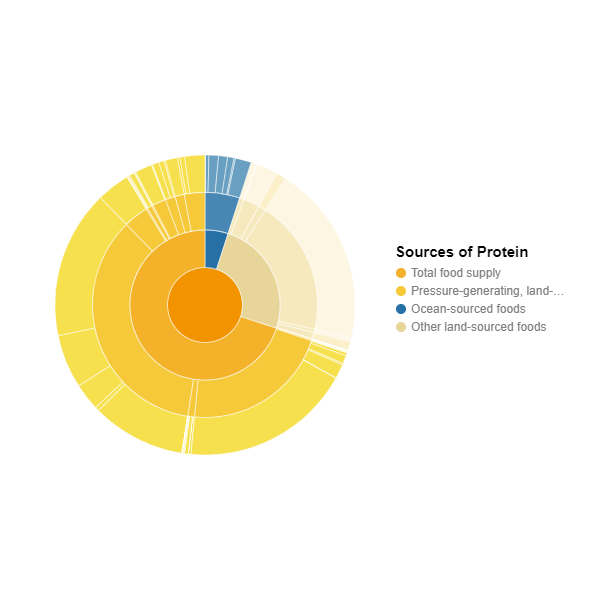

In [5]:
vega_view=dict(spec)
vega_view['legends'][0]['labelFont'] = 'Arial'
vega_view['legends'][0]['titleFont'] = 'Arial'
vega_view['height'] = widget_height
vega_view['width'] = widget_width
vega_view['data'][0]['url']= vega_view['data'][0]['url'].replace('{{geostore_env}}','geostore_prod')
vega_view['data'][0]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','f653d0a434168104f4bdcdf8c712d079')
Vega(vega_view)

[Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAATONABONHJnaT0AQXEACOAA8kCHABs4OtgDMdSHRBxIocALSWGJkzXFkdipLJokEx0TJABPNgZMHUs2RR0YGjg-RVgaKCCdWSRMKmkQAHcaWXo0AQAGcpl4GjIsNABmSpkHWQDvMpkkKLYIGgAvODQQVvy+snEgiDQAbVBJhCH0MLgkRXziIIYlgCZygEYADhkmL1k0UC8cKOG-byGZBC80fYBOADZ9x6R9ND2jmQQTBwHAvAC+YKk8yMSxAUEi4kwijCGy2sIAwgB5AAy+VO4nOqEu4mumGGEDgZigZJkbFU6mmqBmIAAQgAlTT5ACSABEAHL5LG4mQAUQAKgAJfIAWRFAA1uXyefkRQBlMWCiUCmQAcXZ+T52OVMjFAFU2flTarOTIAFIABQFAF0IU6ZNlcrNoYthrkmGZ8gxFCZhlhcPgiAVlM5FAVKBlFJg2PG2AgCEgcDQSDtOABHEwAflzAF4dKqRdiReixTZPEgIKwxDYIDpaLIAPpVLI5KhrVZSHQrNYDuiIZs6YoDhyKOCIgd9QYDzYmbbjnCKNjArwDpCTExhPoQdsZYFkOJhKcb2QMak6ABibMx0p0AApy5XqzoAFT3x-P2JsJ2nztrG+ztv62ztgBHYQAwOCmGE7ZwAEmAAJTdrkOhcnyfIimyOi2pi2EWAU7ZBIEfTeMeCJIkkLaaKqtYUTomJ8kx9aUOR9Y6KWHq9jOtiYmyPJ4ToLIAJo2HuB40EeJ7kOeOgMeiI6yEpqrovksSKMgZJEiAmBhDgsKiBI+TrnSySGbcbAFNMkIGXcEDaQgXoGUZsKWDQJjAusMgGOuwwegwCDUMUnY8aW8IMIiyIgJCoCGcZwxeT5yT5AF6zoMFoVDooxbFnl8VQu5yXoECfhqJYKIyAA1nAKLoMU5l9oiADSDXDNOs5kglpWwtOahqGZMheZShIgAuDyTXEemgGNJiEsyu5BDJck5ApcUuoCAxLHMk21Huww7N+Oj2lyxWgOMR3oEUJQwAQAAs8VuiA9azG95T5IoX1dPs33-e6IKlDIaSLTOkiva07RkGg5Rgi6r3QEEChuQssJmGQs7nDISWwnE7RBPksipkgzxMiAYqbpk0F2HBCH5PaM4QLBM7OFj4jJDkXhkAOoQEs4YhBk4anQdMMiYk4u6C5EqTITEbBsLI4sgJi9DJCEu6yDLwvy2LICvXcWMfQAxJYDRMDsOyvPkZsCFArwNCgMgmzs7wAOzlEgAi23AhyyAIrwoNt3qwhBqO4x5wyeJzazE6T5OgHxvpIP600LRN8iqDAxUgEbe0gK7Htez7LsNLI7uWEg00mwIDSHJYTDu7b7yvK8lhQF9r0k8gXjSuTXx53ApCKBSaBVyYFJ9ejwxkDOB75HjwwE14RPugnGhJz2Kdp1pSSLUFwM5w5+em5YOxwDslu25Y7twK8TA1x3ljlBkvv+4HwfTzCy-5yrS-oBjqsPycgN4XDkNvdAfoAyjX3pnI+udT4UzNhbK2NsXaWEelAfYj1AaF0sPbR2zt8HvADo9Z6GD3hwHKI9IY3cN79w0IPGcI8x6oAnlPEqM90B0kcHQGq-Vo5eGAfHXum8IGeiganGBIAM6H2zrnHuZNxCMJeDIFhyQ2FIm2Oo3cxsmTlEoIcAQUh9iI2+IoWqjJ9oALeqkLSG5XL6WTlI3eDlZzwnkOAnq6V9K-H0tdImt1ij0AIA0XOjUrqHSCRgOAtQsAEB2LnfoZwDDgOXNscEtIHBQH4W5YEQJfQKEwC+Agqo4DwgJGsMIBABw5UoBZa81JUKohXEsQxAg+oZKWPsBGsCPBuWRgGAJ0SQzoBfPUla+5DzHg2meZEkVSwAHI1bwHiNiLWzhVSyxFveRWyslk6ALDoJZc8GoQCWagDCIVOLSRmfJeZYRFknMlqscQWydnyzvPsi5RyTnh1+VcpZcQ9EKCWS0hycjsoIL6QZRWPkVDgMCWMyapg6ATJyDcycSz2zgpmOUJ0OgADUr56kWS3LoY5lyTnEoVjpHIL4MWYBueSuJ4hUIDiWZQfYlhwW0sOWQAgGRMy5AINkMIhygXgvig5OCHolhXVyImbQZBhnzTgcMJAX13EEhVWq2RGr0BIH+g5LwnNFBsn8DQBgjJ1XjVuNq2kURkiWoCDa8BUK84msBEiNg9V0lomGAURIwJc4VT9XAAA6iEnO+lulw0oJ0mQKSCRpLjYG1AvSHIwDYCPJFvr-XprabcZCYaC1RpjQG4tqAdgORTfIfxoB42oHhhCWFmNsbWMSnQYZzJtm6xbFYM6G4KUG1pMoHqwxxASGmh2gkCoRkTBiXdegX5KDvB9g5OdshxJItGaGOJdRMBrueg5WxEAwgICYGwEM-SUXbsXj2uA3zESql2nupdKKV0PUeo6gyT6X16RAJoZQa8QChEfiYQDb7BgfpuoUGNBAKi5wg5SQDwwQOBFvXCTwOAJSHvqJm94-lxCeIVeB1OlJbUgC8L5RwahSBoG0XAEjvlwFJhvWoUEi74P1NQyGCEMg5UbQ9d5MZTaM0gDOSiQTGBc2+PVQMotmT0BeRnEwZQUBaoyrbS6IAA)

# Indicator

## Rank

Query:
```sql
SELECT 
    CONCAT(rank, ' of ', max_rank) 
    FROM (
        SELECT 
            gid_0,
            geostore_prod, 
            rank, 
            MAX(rank) OVER (PARTITION BY true) AS max_rank 
        FROM (
            SELECT 
                gid_0,
                geostore_prod,  
                RANK() OVER(ORDER BY prop DESC) as rank 
            FROM (
                SELECT 
                    area, 
                    SUM(
                    CASE
                        WHEN item = 'Ocean-Sourced Foods' THEN value 
                        ELSE 0
                    END)/
                    NULLIF(
                        SUM(
                            CASE
                                WHEN item = 'Grand Total' THEN value
                                ELSE 0
                            END),0) prop
                FROM ocn_calcs_015_blue_food_protein_supply 
                WHERE year = 2018 GROUP BY area) data 
        LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = data.area 
    LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 
    WHERE prop is not null AND coastal = true) ranked
GROUP BY rank, geostore_prod, gid_0) max_rank
WHERE {{geostore_env}} ILIKE '{{geostore_id}}'
```

query: [https://wri-rw.carto.com/api/v2/sql?q=SELECT CONCAT(rank, ' of ', max_rank) AS rank FROM (SELECT gid_0, geostore_prod,rank, MAX(rank) OVER (PARTITION BY true) AS max_rank FROM (SELECT gid_0, geostore_prod,RANK() OVER(ORDER BY prop DESC) as rank FROM (SELECT area, SUM(CASE WHEN item = 'Ocean-Sourced Foods' THEN value ELSE 0 END)/NULLIF(SUM(CASE WHEN item = 'Grand Total' THEN value ELSE 0 END),0) prop FROM ocn_calcs_015_blue_food_protein_supply WHERE year = 2018 GROUP BY area) data LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = data.area LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE prop is not null AND coastal = true) ranked GROUP BY rank, geostore_prod, gid_0) max_rank WHERE {{geostore_env}} ILIKE '{{geostore_id}}'](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20CONCAT(rank,%20%27%20of%20%27,%20max_rank)%20AS%20rank%20FROM%20(SELECT%20gid_0,%20geostore_prod,rank,%20MAX(rank)%20OVER%20(PARTITION%20BY%20true)%20AS%20max_rank%20FROM%20(SELECT%20gid_0,%20geostore_prod,RANK()%20OVER(ORDER%20BY%20prop%20DESC)%20as%20rank%20FROM%20(SELECT%20area,%20SUM(CASE%20WHEN%20item%20=%20%27Ocean-Sourced%20Foods%27%20THEN%20value%20ELSE%200%20END)/NULLIF(SUM(CASE%20WHEN%20item%20=%20%27Grand%20Total%27%20THEN%20value%20ELSE%200%20END),0)%20prop%20FROM%20ocn_calcs_015_blue_food_protein_supply%20WHERE%20year%20=%202018%20GROUP%20BY%20area)%20data%20LEFT%20JOIN%20ow_aliasing_countries%20AS%20alias%20ON%20alias.alias%20=%20data.area%20LEFT%20JOIN%20gadm36_0%20gadm%20ON%20alias.iso%20=%20gadm.gid_0%20WHERE%20prop%20is%20not%20null%20AND%20coastal%20=%20true)%20ranked%20GROUP%20BY%20rank,%20geostore_prod,%20gid_0)%20max_rank%20WHERE%20gid_0%20ILIKE%20%27MEX%27)

## Value

Description: Blue protein as a proportion of total protein

Query:
``` sql
SELECT SUM(ocean_value)/NULLIF(SUM(total_value),0)*100 AS value FROM (SELECT area, year, item, CASE
	WHEN item = 'Ocean-Sourced Foods' THEN value 
    ELSE 0
    END ocean_value,
CASE
    WHEN item = 'Grand Total' THEN value
    ELSE 0
    END total_value
FROM ocn_calcs_015_blue_food_protein_supply
WHERE year = 2018) data
LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = data.area 
LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 
WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}'
GROUP by area
```

query: [https://wri-rw.carto.com/api/v2/sql?q=SELECT SUM(ocean_value)/NULLIF(SUM(total_value),0)*100 AS value FROM (SELECT area, year, item, CASE WHEN item = 'Ocean-Sourced Foods' THEN value ELSE 0 END ocean_value, CASE WHEN item = 'Grand Total' THEN value ELSE 0 END total_value FROM ocn_calcs_015_blue_food_protein_supply WHERE year = 2018) data LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = data.area LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' GROUP by area](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20SUM(ocean_value)/NULLIF(SUM(total_value),0)*100%20AS%20value%20FROM%20(SELECT%20area,%20year,%20item,%20CASE%20WHEN%20item%20=%20%27Ocean-Sourced%20Foods%27%20THEN%20value%20ELSE%200%20END%20ocean_value,%20CASE%20WHEN%20item%20=%20%27Grand%20Total%27%20THEN%20value%20ELSE%200%20END%20total_value%20FROM%20ocn_calcs_015_blue_food_protein_supply%20WHERE%20year%20=%202018)%20data%20LEFT%20JOIN%20ow_aliasing_countries%20AS%20alias%20ON%20alias.alias%20=%20data.area%20LEFT%20JOIN%20gadm36_0%20gadm%20ON%20alias.iso%20=%20gadm.gid_0%20WHERE%20gadm.gid_0%20ILIKE%20%27MEX%27%20GROUP%20by%20area)

## RW API

- [back office](https://resourcewatch.org/admin/data/widgets/731293a0-b92f-4804-b59c-69a1d794ad73/edit?dataset=9e1b3cad-db6f-44b0-b6fb-048df7b6c680)
- parent dataset [foo_061](https://resourcewatch.org/data/explore/9e1b3cad-db6f-44b0-b6fb-048df7b6c680) 
- dataset id ```9e1b3cad-db6f-44b0-b6fb-048df7b6c680```
- widget id: ```731293a0-b92f-4804-b59c-69a1d794ad73```